# 5. Advanced PINN Techniques - PyTorch Implementation

This notebook demonstrates cutting-edge PINN techniques using pure PyTorch:

1. **Gradient-Enhanced PINNs (gPINN)**: Incorporating derivative data into the loss
2. **Causal Training**: Respecting temporal causality in time-dependent problems
3. **Multi-Objective Optimization**: Balancing competing loss terms
4. **Advanced Loss Functions**: Adaptive weighting and specialized formulations

### Problem Setup:
We'll demonstrate these techniques on the 1D Burgers equation:
- **PDE**: $\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$
- **Domain**: $x \in [-1, 1]$, $t \in [0, 1]$
- **Initial Condition**: $u(x, 0) = -\sin(\pi x)$
- **Boundary Conditions**: $u(\pm 1, t) = 0$
- **Viscosity**: $\nu = 0.01/\pi$

This nonlinear PDE exhibits rich dynamics and provides an excellent testbed for advanced techniques.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set device and style
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Problem parameters
nu = 0.01 / np.pi  # Kinematic viscosity
print(f"Kinematic viscosity ν = {nu:.6f}")


Using device: cuda
Kinematic viscosity ν = 0.003183


## 1. Advanced Neural Network Architectures

In [2]:
class AdvancedPINN(nn.Module):
    """Advanced PINN with multiple architectural options"""
    
    def __init__(self, input_dim=2, hidden_dim=50, output_dim=1, num_layers=6, 
                 activation='tanh', use_fourier_features=False, fourier_scale=1.0):
        super(AdvancedPINN, self).__init__()
        
        self.use_fourier_features = use_fourier_features
        self.fourier_scale = fourier_scale
        
        # Fourier feature embedding
        if use_fourier_features:
            self.fourier_dim = 20
            self.B = nn.Parameter(
                torch.randn(input_dim, self.fourier_dim) * fourier_scale,
                requires_grad=False
            )
            actual_input_dim = 2 * self.fourier_dim
        else:
            actual_input_dim = input_dim
        
        # Network layers
        layers = []
        layers.append(nn.Linear(actual_input_dim, hidden_dim))
        
        # Activation function
        if activation == 'tanh':
            act_fn = nn.Tanh()
        elif activation == 'swish':
            act_fn = nn.SiLU()
        elif activation == 'gelu':
            act_fn = nn.GELU()
        else:
            act_fn = nn.Tanh()
        
        for _ in range(num_layers):
            layers.append(act_fn)
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        layers.append(act_fn)
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        self.init_weights()
    
    def init_weights(self):
        """Advanced weight initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Xavier initialization with gain for activation function
                nn.init.xavier_normal_(module.weight, gain=1.0)
                nn.init.zeros_(module.bias)
    
    def fourier_feature_embedding(self, x):
        """Apply Fourier feature embedding"""
        if not self.use_fourier_features:
            return x
        
        # Compute 2π * B^T * x
        x_proj = 2 * np.pi * x @ self.B
        
        # Return concatenated sin and cos features
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    
    def forward(self, x):
        if self.use_fourier_features:
            x = self.fourier_feature_embedding(x)
        return self.network(x)

class MultiTaskPINN(nn.Module):
    """Multi-task PINN for handling multiple outputs/objectives"""
    
    def __init__(self, input_dim=2, hidden_dim=50, num_outputs=1, num_layers=4):
        super(MultiTaskPINN, self).__init__()
        
        # Shared backbone
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Task-specific heads
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim//2),
                nn.Tanh(),
                nn.Linear(hidden_dim//2, 1)
            ) for _ in range(num_outputs)
        ])
        
        self.init_weights()
    
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x, head_idx=0):
        features = self.backbone(x)
        return self.heads[head_idx](features)
    
    def forward_all_heads(self, x):
        features = self.backbone(x)
        return [head(features) for head in self.heads]

# Create models for comparison
standard_model = AdvancedPINN(
    input_dim=2, hidden_dim=50, output_dim=1, num_layers=6, 
    activation='tanh', use_fourier_features=False
).to(device)

fourier_model = AdvancedPINN(
    input_dim=2, hidden_dim=50, output_dim=1, num_layers=6,
    activation='tanh', use_fourier_features=True, fourier_scale=1.0
).to(device)

multitask_model = MultiTaskPINN(
    input_dim=2, hidden_dim=50, num_outputs=1, num_layers=4
).to(device)

print(f"Standard model parameters: {sum(p.numel() for p in standard_model.parameters()):,}")
print(f"Fourier model parameters: {sum(p.numel() for p in fourier_model.parameters()):,}")
print(f"Multi-task model parameters: {sum(p.numel() for p in multitask_model.parameters()):,}")

Standard model parameters: 15,501
Fourier model parameters: 17,441
Multi-task model parameters: 6,551


## 2. Advanced Data Generation and Sampling

Generating reference solution...
Reference solution shape: (101, 201)

Training data summary:
  Domain points: torch.Size([5000, 2])
  Boundary points: torch.Size([100, 2])
  Initial points: torch.Size([200, 2])
  Observation points: torch.Size([150, 2])
  Gradient points: torch.Size([75, 2])


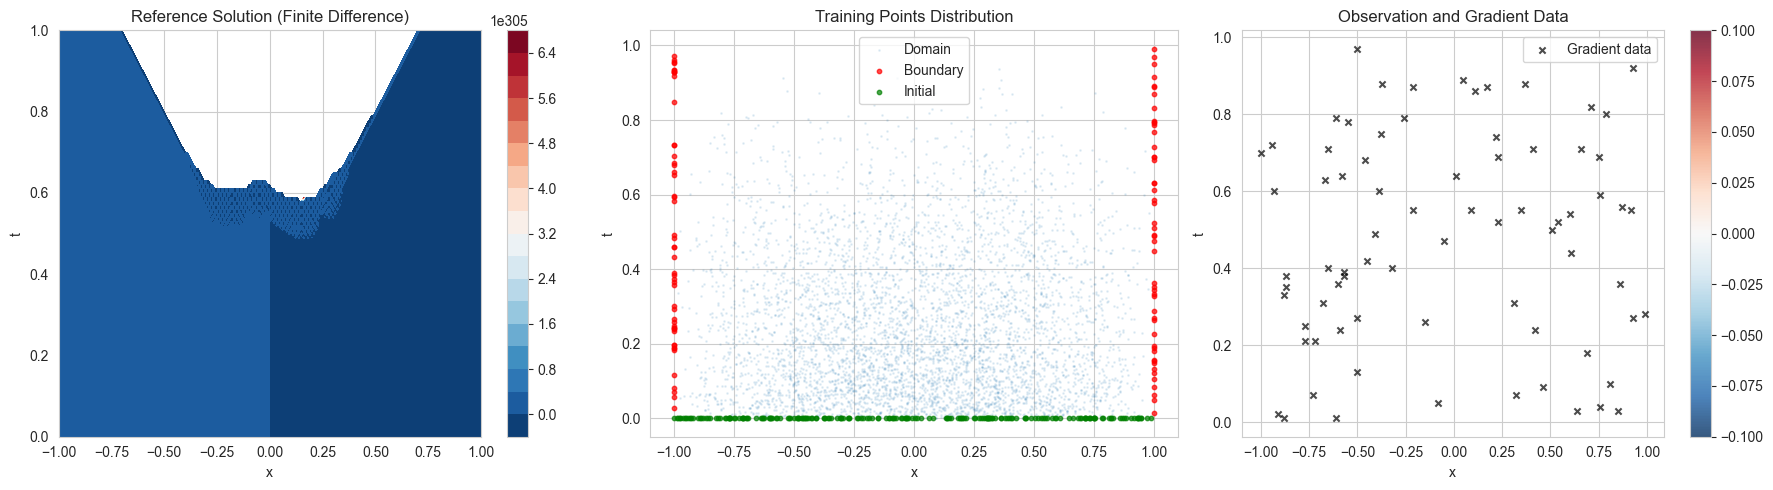

In [3]:
def generate_reference_solution():
    """Generate high-fidelity reference solution using finite differences"""
    # Spatial and temporal grids
    nx, nt = 201, 101
    x = np.linspace(-1, 1, nx)
    t = np.linspace(0, 1, nt)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    
    # Initialize solution array
    u = np.zeros((nt, nx))
    
    # Initial condition: u(x, 0) = -sin(πx)
    u[0, :] = -np.sin(np.pi * x)
    
    # Time-stepping with upwind scheme for nonlinear term
    for n in range(nt - 1):
        u_old = u[n, :].copy()
        
        for i in range(1, nx - 1):
            # Nonlinear advection term (upwind)
            if u_old[i] >= 0:
                advection = u_old[i] * (u_old[i] - u_old[i-1]) / dx
            else:
                advection = u_old[i] * (u_old[i+1] - u_old[i]) / dx
            
            # Viscous term (central difference)
            viscous = nu * (u_old[i+1] - 2*u_old[i] + u_old[i-1]) / dx**2
            
            # Update
            u[n+1, i] = u_old[i] + dt * (-advection + viscous)
        
        # Boundary conditions: u(±1, t) = 0
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return x, t, u

def sample_training_points(num_domain=5000, num_boundary=100, num_initial=200, 
                          adaptive_sampling=False, shock_region_weight=2.0):
    """Generate training points with optional adaptive sampling"""
    
    if adaptive_sampling:
        # More points near shock formation regions
        # Domain points with bias toward center and early times
        x_domain = np.random.beta(2, 2, num_domain) * 2 - 1  # Beta distribution biased toward center
        t_domain = np.random.beta(1, 3, num_domain)  # More points at early times
    else:
        # Uniform sampling
        x_domain = np.random.uniform(-1, 1, num_domain)
        t_domain = np.random.uniform(0, 1, num_domain)
    
    domain_points = np.column_stack([x_domain, t_domain])
    
    # Boundary points
    t_boundary = np.random.uniform(0, 1, num_boundary)
    x_left = np.full(num_boundary//2, -1.0)
    x_right = np.full(num_boundary//2, 1.0)
    x_boundary = np.concatenate([x_left, x_right])
    t_boundary = np.concatenate([t_boundary[:num_boundary//2], t_boundary[num_boundary//2:]])
    boundary_points = np.column_stack([x_boundary, t_boundary])
    
    # Initial condition points
    x_initial = np.random.uniform(-1, 1, num_initial)
    t_initial = np.zeros(num_initial)
    initial_points = np.column_stack([x_initial, t_initial])
    
    # Convert to tensors
    domain_tensor = torch.tensor(domain_points, dtype=torch.float32, device=device)
    boundary_tensor = torch.tensor(boundary_points, dtype=torch.float32, device=device)
    initial_tensor = torch.tensor(initial_points, dtype=torch.float32, device=device)
    
    return domain_tensor, boundary_tensor, initial_tensor

def generate_observation_data(x_ref, t_ref, u_ref, num_obs=100, noise_level=0.01):
    """Generate sparse observation data from reference solution"""
    # Random sampling from reference grid
    X_ref, T_ref = np.meshgrid(x_ref, t_ref)
    
    # Sample observation points
    indices = np.random.choice(X_ref.size, num_obs, replace=False)
    x_obs = X_ref.flatten()[indices]
    t_obs = T_ref.flatten()[indices]
    u_obs = u_ref.flatten()[indices]
    
    # Add noise
    if noise_level > 0:
        noise = np.random.normal(0, noise_level * np.std(u_obs), num_obs)
        u_obs_noisy = u_obs + noise
    else:
        u_obs_noisy = u_obs
    
    # Convert to tensors
    obs_points = torch.tensor(np.column_stack([x_obs, t_obs]), dtype=torch.float32, device=device)
    obs_values = torch.tensor(u_obs_noisy.reshape(-1, 1), dtype=torch.float32, device=device)
    
    return obs_points, obs_values

def generate_gradient_data(x_ref, t_ref, u_ref, num_grad_obs=50):
    """Generate gradient observation data for gPINN"""
    dx = x_ref[1] - x_ref[0]
    dt = t_ref[1] - t_ref[0]
    
    # Compute gradients using finite differences
    u_x = np.gradient(u_ref, dx, axis=1)
    u_t = np.gradient(u_ref, dt, axis=0)
    
    # Sample gradient observation points
    X_ref, T_ref = np.meshgrid(x_ref, t_ref)
    indices = np.random.choice(X_ref.size, num_grad_obs, replace=False)
    
    x_grad = X_ref.flatten()[indices]
    t_grad = T_ref.flatten()[indices]
    ux_grad = u_x.flatten()[indices]
    ut_grad = u_t.flatten()[indices]
    
    # Convert to tensors
    grad_points = torch.tensor(np.column_stack([x_grad, t_grad]), dtype=torch.float32, device=device)
    grad_ux = torch.tensor(ux_grad.reshape(-1, 1), dtype=torch.float32, device=device)
    grad_ut = torch.tensor(ut_grad.reshape(-1, 1), dtype=torch.float32, device=device)
    
    return grad_points, grad_ux, grad_ut

# Generate reference solution and training data
print("Generating reference solution...")
x_ref, t_ref, u_ref = generate_reference_solution()
print(f"Reference solution shape: {u_ref.shape}")

# Generate training points
domain_points, boundary_points, initial_points = sample_training_points(
    num_domain=5000, num_boundary=100, num_initial=200, adaptive_sampling=True
)

# Generate observation data
obs_points, obs_values = generate_observation_data(x_ref, t_ref, u_ref, num_obs=150, noise_level=0.02)
grad_points, grad_ux, grad_ut = generate_gradient_data(x_ref, t_ref, u_ref, num_grad_obs=75)

print(f"\nTraining data summary:")
print(f"  Domain points: {domain_points.shape}")
print(f"  Boundary points: {boundary_points.shape}")
print(f"  Initial points: {initial_points.shape}")
print(f"  Observation points: {obs_points.shape}")
print(f"  Gradient points: {grad_points.shape}")

# Visualize reference solution and sampling
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Reference solution
X_ref, T_ref = np.meshgrid(x_ref, t_ref)
im1 = axes[0].contourf(X_ref, T_ref, u_ref, levels=20, cmap='RdBu_r')
axes[0].set_title('Reference Solution (Finite Difference)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
plt.colorbar(im1, ax=axes[0])

# Training points distribution
domain_np = domain_points.cpu().numpy()
axes[1].scatter(domain_np[:, 0], domain_np[:, 1], alpha=0.1, s=1, label='Domain')
boundary_np = boundary_points.cpu().numpy()
axes[1].scatter(boundary_np[:, 0], boundary_np[:, 1], alpha=0.7, s=10, color='red', label='Boundary')
initial_np = initial_points.cpu().numpy()
axes[1].scatter(initial_np[:, 0], initial_np[:, 1], alpha=0.7, s=10, color='green', label='Initial')
axes[1].set_title('Training Points Distribution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].legend()

# Observation data
obs_np = obs_points.cpu().numpy()
obs_vals_np = obs_values.cpu().numpy().flatten()
scatter = axes[2].scatter(obs_np[:, 0], obs_np[:, 1], c=obs_vals_np, cmap='RdBu_r', s=30, alpha=0.8)
grad_np = grad_points.cpu().numpy()
axes[2].scatter(grad_np[:, 0], grad_np[:, 1], marker='x', color='black', s=20, alpha=0.7, label='Gradient data')
axes[2].set_title('Observation and Gradient Data')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].legend()
plt.colorbar(scatter, ax=axes[2])

plt.tight_layout()
plt.show()

## 3. Advanced Loss Functions and Training Strategies

In [4]:
class AdvancedLossComputer:
    """Advanced loss computation with multiple techniques"""
    
    def __init__(self, model, loss_weights=None, adaptive_weights=True, 
                 causal_training=False, gradient_enhanced=False):
        self.model = model
        self.adaptive_weights = adaptive_weights
        self.causal_training = causal_training
        self.gradient_enhanced = gradient_enhanced
        
        # Default loss weights
        self.loss_weights = loss_weights or {
            'pde': 1.0, 'boundary': 1.0, 'initial': 1.0, 'data': 1.0, 'gradient': 1.0
        }
        
        # For adaptive weighting
        self.loss_history = defaultdict(list)
        self.alpha_adaptive = 0.95  # Exponential moving average factor
        
        # For causal training
        self.current_time = 0.0
        self.causal_window = 0.1
    
    def compute_derivatives(self, u, points):
        """Compute spatial and temporal derivatives"""
        grad = torch.autograd.grad(
            outputs=u,
            inputs=points,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        u_x = grad[:, 0:1]  # ∂u/∂x
        u_t = grad[:, 1:2]  # ∂u/∂t
        
        # Second derivative ∂²u/∂x²
        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=points,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True
        )[0][:, 0:1]
        
        return u_t, u_x, u_xx
    
    def causal_weight(self, points, current_time):
        """Compute causal weighting based on temporal distance"""
        if not self.causal_training:
            return torch.ones(points.shape[0], 1, device=points.device)
        
        t = points[:, 1:2]  # Time coordinate
        
        # Exponential decay for future points
        future_mask = t > current_time
        weights = torch.ones_like(t)
        
        if torch.any(future_mask):
            future_weights = torch.exp(-10 * torch.clamp((t[future_mask] - current_time) / self.causal_window, 0, 2))
            weights[future_mask] = future_weights
        
        return weights
    
    def adaptive_weight_update(self, losses):
        """Update loss weights using gradient-based balancing"""
        if not self.adaptive_weights:
            return self.loss_weights
        
        # Record loss history
        for key, value in losses.items():
            if key != 'total':
                self.loss_history[key].append(value)
        
        # Only start adapting after some history is accumulated
        if len(self.loss_history['pde']) < 10:
            return self.loss_weights
        
        # Compute moving averages
        avg_losses = {}
        for key in self.loss_weights.keys():
            if key in self.loss_history and self.loss_history[key]:
                recent_losses = self.loss_history[key][-10:]
                avg_losses[key] = np.mean(recent_losses)
        
        if len(avg_losses) < 2:
            return self.loss_weights
        
        # Balance weights based on relative loss magnitudes
        total_avg = sum(avg_losses.values())
        target_weight = total_avg / len(avg_losses)
        
        updated_weights = {}
        for key in self.loss_weights.keys():
            if key in avg_losses:
                # Increase weight if loss is too small, decrease if too large
                ratio = target_weight / (avg_losses[key] + 1e-10)
                # Smooth update
                updated_weights[key] = self.alpha_adaptive * self.loss_weights[key] + \
                                     (1 - self.alpha_adaptive) * self.loss_weights[key] * ratio
                # Clamp weights to reasonable range
                updated_weights[key] = np.clip(updated_weights[key], 0.1, 10.0)
            else:
                updated_weights[key] = self.loss_weights[key]
        
        self.loss_weights = updated_weights
        return self.loss_weights
    
    def compute_pde_loss(self, domain_points, current_time=0.0):
        """Compute PDE residual loss with optional causal weighting"""
        domain_points.requires_grad_(True)
        
        # Forward pass
        u_domain = self.model(domain_points)
        u_t, u_x, u_xx = self.compute_derivatives(u_domain, domain_points)
        
        # Burgers equation residual: u_t + u*u_x - ν*u_xx = 0
        pde_residual = u_t + u_domain * u_x - nu * u_xx
        
        # Apply causal weighting
        if self.causal_training:
            causal_weights = self.causal_weight(domain_points, current_time)
            weighted_residual = pde_residual * causal_weights
            loss_pde = torch.mean(weighted_residual**2)
        else:
            loss_pde = torch.mean(pde_residual**2)
        
        return loss_pde
    
    def compute_gradient_loss(self, grad_points, grad_ux_target, grad_ut_target):
        """Compute gradient-enhanced loss (gPINN)"""
        if not self.gradient_enhanced:
            return torch.tensor(0.0, device=device)
        
        grad_points.requires_grad_(True)
        u_grad = self.model(grad_points)
        u_t_pred, u_x_pred, _ = self.compute_derivatives(u_grad, grad_points)
        
        # Gradient matching losses
        loss_grad_x = torch.mean((u_x_pred - grad_ux_target)**2)
        loss_grad_t = torch.mean((u_t_pred - grad_ut_target)**2)
        
        return loss_grad_x + loss_grad_t
    
    def compute_boundary_loss(self, boundary_points):
        """Compute boundary condition loss"""
        u_boundary = self.model(boundary_points)
        bc_target = torch.zeros_like(u_boundary)
        return torch.mean((u_boundary - bc_target)**2)
    
    def compute_initial_loss(self, initial_points):
        """Compute initial condition loss"""
        u_initial = self.model(initial_points)
        x_coord = initial_points[:, 0:1]
        ic_target = -torch.sin(np.pi * x_coord)
        return torch.mean((u_initial - ic_target)**2)
    
    def compute_data_loss(self, obs_points, obs_values):
        """Compute data fitting loss"""
        u_pred = self.model(obs_points)
        return torch.mean((u_pred - obs_values)**2)
    
    def compute_total_loss(self, domain_points, boundary_points, initial_points,
                          obs_points, obs_values, grad_points=None, grad_ux=None, grad_ut=None,
                          current_time=0.0):
        """Compute total weighted loss"""
        
        losses = {}
        
        # Compute individual losses
        losses['pde'] = self.compute_pde_loss(domain_points, current_time)
        losses['boundary'] = self.compute_boundary_loss(boundary_points)
        losses['initial'] = self.compute_initial_loss(initial_points)
        losses['data'] = self.compute_data_loss(obs_points, obs_values)
        
        if self.gradient_enhanced and grad_points is not None:
            losses['gradient'] = self.compute_gradient_loss(grad_points, grad_ux, grad_ut)
        
        # Update adaptive weights
        current_weights = self.adaptive_weight_update(losses)
        
        # Compute weighted total loss
        total_loss = sum(current_weights.get(key, 1.0) * loss 
                        for key, loss in losses.items())
        
        losses['total'] = total_loss
        losses['weights'] = current_weights.copy()
        
        return losses

print("Advanced loss computation classes initialized!")

Advanced loss computation classes initialized!


## 4. Multi-Objective Optimization Strategies

In [7]:
class MultiObjectiveOptimizer:
    """Multi-objective optimization for PINNs"""
    
    def __init__(self, model, method='gradnorm', alpha=1.5):
        self.model = model
        self.method = method
        self.alpha = alpha  # GradNorm parameter
        
        # Initialize task weights
        self.task_weights = nn.Parameter(torch.ones(5, device=device))  # 5 loss terms
        self.initial_losses = None
        
    def compute_gradients(self, losses, shared_params):
        """Compute gradients for each loss term"""
        gradients = []
        
        for loss in losses:
            grad = torch.autograd.grad(
                outputs=loss,
                inputs=shared_params,
                retain_graph=True,
                create_graph=False
            )
            # Concatenate gradients into a single vector
            grad_vec = torch.cat([g.view(-1) for g in grad])
            gradients.append(grad_vec)
        
        return torch.stack(gradients)
    
    def gradnorm_step(self, losses, shared_params):
        """GradNorm optimization step"""
        if self.initial_losses is None:
            self.initial_losses = [loss.item() for loss in losses]
        
        # Compute current loss ratios
        current_losses = [loss.item() for loss in losses]
        loss_ratios = [current / initial for current, initial in 
                      zip(current_losses, self.initial_losses)]
        
        # Target relative training rate
        avg_loss_ratio = np.mean(loss_ratios)
        target_ratios = [(ratio / avg_loss_ratio) ** self.alpha for ratio in loss_ratios]
        
        # Compute gradients
        gradients = self.compute_gradients(losses, shared_params)
        
        # Compute gradient norms
        grad_norms = torch.norm(gradients, dim=1)
        
        # Target gradient norms
        avg_grad_norm = torch.mean(grad_norms)
        target_grad_norms = avg_grad_norm * torch.tensor(target_ratios, device=device)
        
        # GradNorm loss
        gradnorm_loss = torch.sum(torch.abs(grad_norms - target_grad_norms))
        
        # Update task weights
        gradnorm_loss.backward()
        
        # Normalize weights
        with torch.no_grad():
            self.task_weights.data = torch.clamp(self.task_weights.data, 0.1, 10.0)
            self.task_weights.data = self.task_weights.data / torch.mean(self.task_weights.data)
        
        return self.task_weights.detach().cpu().numpy()
    
    def pcgrad_step(self, losses, shared_params):
        """PCGrad (Project Conflicting Gradients) optimization"""
        gradients = self.compute_gradients(losses, shared_params)
        
        # Project conflicting gradients
        modified_grads = []
        
        for i in range(len(gradients)):
            grad_i = gradients[i]
            
            for j in range(len(gradients)):
                if i != j:
                    grad_j = gradients[j]
                    
                    # Check if gradients conflict (negative cosine similarity)
                    cos_sim = torch.dot(grad_i, grad_j) / (torch.norm(grad_i) * torch.norm(grad_j) + 1e-8)
                    
                    if cos_sim < 0:
                        # Project grad_i onto the orthogonal complement of grad_j
                        projection = torch.dot(grad_i, grad_j) / (torch.norm(grad_j)**2 + 1e-8) * grad_j
                        grad_i = grad_i - projection
            
            modified_grads.append(grad_i)
        
        # Average the modified gradients
        final_grad = torch.stack(modified_grads).mean(dim=0)
        
        return final_grad

class AdvancedTrainer:
    """Advanced trainer with multiple optimization strategies"""
    
    def __init__(self, model, loss_computer, moo_optimizer=None):
        self.model = model
        self.loss_computer = loss_computer
        self.moo_optimizer = moo_optimizer
        self.training_history = []
        
    def train_epoch(self, optimizer, domain_points, boundary_points, initial_points,
                   obs_points, obs_values, grad_points=None, grad_ux=None, grad_ut=None,
                   current_time=0.0, use_moo=False):
        """Single training epoch with optional multi-objective optimization"""
        
        optimizer.zero_grad()
        
        # Compute losses
        loss_dict = self.loss_computer.compute_total_loss(
            domain_points, boundary_points, initial_points,
            obs_points, obs_values, grad_points, grad_ux, grad_ut, current_time
        )
        
        if use_moo and self.moo_optimizer:
            # Multi-objective optimization
            individual_losses = [loss_dict['pde'], loss_dict['boundary'], 
                               loss_dict['initial'], loss_dict['data']]
            
            if 'gradient' in loss_dict:
                individual_losses.append(loss_dict['gradient'])
            else:
                individual_losses.append(torch.tensor(0.0, device=device))
            
            # Get shared parameters (all model parameters)
            shared_params = list(self.model.parameters())
            
            if self.moo_optimizer.method == 'gradnorm':
                weights = self.moo_optimizer.gradnorm_step(individual_losses, shared_params)
                # Recompute weighted loss
                weighted_loss = sum(w * loss for w, loss in zip(weights, individual_losses))
                weighted_loss.backward()
            elif self.moo_optimizer.method == 'pcgrad':
                final_grad = self.moo_optimizer.pcgrad_step(individual_losses, shared_params)
                # Apply the final gradient
                start_idx = 0
                for param in self.model.parameters():
                    end_idx = start_idx + param.numel()
                    param.grad = final_grad[start_idx:end_idx].view(param.shape)
                    start_idx = end_idx
        else:
            # Standard training
            loss_dict['total'].backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        return loss_dict
    
    def train(self, domain_points, boundary_points, initial_points, obs_points, obs_values,
              grad_points=None, grad_ux=None, grad_ut=None, epochs=10000, lr=1e-3,
              use_causal=False, use_moo=False, print_every=1000):
        """Full training loop with advanced techniques"""
        
        # Setup optimizer
        if use_moo and self.moo_optimizer and self.moo_optimizer.method == 'gradnorm':
            # Separate optimizers for model and task weights
            model_optimizer = optim.Adam(self.model.parameters(), lr=lr)
            weight_optimizer = optim.Adam([self.moo_optimizer.task_weights], lr=0.01)
        else:
            model_optimizer = optim.Adam(self.model.parameters(), lr=lr)
            weight_optimizer = None
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            model_optimizer, mode='min', factor=0.8, patience=1000
        )
        
        print(f"Starting training with:")
        print(f"  Epochs: {epochs}")
        print(f"  Causal training: {use_causal}")
        print(f"  Multi-objective: {use_moo}")
        print(f"  Gradient enhanced: {self.loss_computer.gradient_enhanced}")
        print(f"  Adaptive weights: {self.loss_computer.adaptive_weights}")
        
        start_time = time.time()
        
        for epoch in range(epochs):
            # Current time for causal training (linear progression)
            current_time = (epoch / epochs) * 1.0 if use_causal else 0.0
            
            # Training step
            loss_dict = self.train_epoch(
                model_optimizer, domain_points, boundary_points, initial_points,
                obs_points, obs_values, grad_points, grad_ux, grad_ut,
                current_time, use_moo
            )
            
            # Update weight optimizer if using GradNorm
            if weight_optimizer:
                weight_optimizer.step()
                weight_optimizer.zero_grad()
            
            # Update scheduler
            scheduler.step(loss_dict['total'])
            
            # Record history
            history_entry = {
                'epoch': epoch,
                'current_time': current_time,
                **{k: v.item() if torch.is_tensor(v) else v 
                   for k, v in loss_dict.items() if k != 'weights'},
                'lr': model_optimizer.param_groups[0]['lr']
            }
            
            if 'weights' in loss_dict:
                history_entry['weights'] = loss_dict['weights']
            
            self.training_history.append(history_entry)
            
            # Print progress
            if (epoch + 1) % print_every == 0:
                elapsed = time.time() - start_time
                print(f"Epoch {epoch+1:5d}/{epochs} | "
                      f"Total: {loss_dict['total'].item():.2e} | "
                      f"PDE: {loss_dict['pde'].item():.2e} | "
                      f"Data: {loss_dict['data'].item():.2e} | "
                      f"Time: {elapsed:.1f}s")
                
                if self.loss_computer.adaptive_weights and 'weights' in loss_dict:
                    weights_str = ", ".join([f"{k}:{v:.2f}" for k, v in loss_dict['weights'].items()])
                    print(f"        Weights: {weights_str}")
                
                start_time = time.time()
        
        return self.training_history

print("Multi-objective optimization and training classes initialized!")

Multi-objective optimization and training classes initialized!
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


## 5. Comparative Experiments

Now let's run experiments comparing different advanced techniques.

In [8]:
def run_comparative_experiments():
    """Run experiments comparing different advanced PINN techniques"""
    
    experiments = {
        'Baseline': {
            'model': AdvancedPINN(use_fourier_features=False).to(device),
            'loss_config': {'adaptive_weights': False, 'causal_training': False, 'gradient_enhanced': False},
            'train_config': {'use_causal': False, 'use_moo': False}
        },
        'Fourier Features': {
            'model': AdvancedPINN(use_fourier_features=True, fourier_scale=1.0).to(device),
            'loss_config': {'adaptive_weights': False, 'causal_training': False, 'gradient_enhanced': False},
            'train_config': {'use_causal': False, 'use_moo': False}
        },
        'Gradient Enhanced': {
            'model': AdvancedPINN(use_fourier_features=False).to(device),
            'loss_config': {'adaptive_weights': False, 'causal_training': False, 'gradient_enhanced': True},
            'train_config': {'use_causal': False, 'use_moo': False}
        },
        'Adaptive + Causal': {
            'model': AdvancedPINN(use_fourier_features=False).to(device),
            'loss_config': {'adaptive_weights': True, 'causal_training': True, 'gradient_enhanced': False},
            'train_config': {'use_causal': True, 'use_moo': False}
        },
        'Full Advanced': {
            'model': AdvancedPINN(use_fourier_features=True, fourier_scale=0.5).to(device),
            'loss_config': {'adaptive_weights': True, 'causal_training': True, 'gradient_enhanced': True},
            'train_config': {'use_causal': True, 'use_moo': True}
        }
    }
    
    results = {}
    
    print("\n" + "="*80)
    print("              COMPARATIVE ADVANCED PINN EXPERIMENTS")
    print("="*80)
    
    for exp_name, config in experiments.items():
        print(f"\n\nRunning Experiment: {exp_name}")
        print("-" * 50)
        
        # Setup loss computer
        loss_computer = AdvancedLossComputer(config['model'], **config['loss_config'])
        
        # Setup multi-objective optimizer if needed
        moo_optimizer = None
        if config['train_config']['use_moo']:
            moo_optimizer = MultiObjectiveOptimizer(config['model'], method='gradnorm', alpha=1.5)
        
        # Setup trainer
        trainer = AdvancedTrainer(config['model'], loss_computer, moo_optimizer)
        
        # Train
        start_time = time.time()
        
        # Prepare gradient data if needed
        grad_args = {}
        if config['loss_config']['gradient_enhanced']:
            grad_args = {'grad_points': grad_points, 'grad_ux': grad_ux, 'grad_ut': grad_ut}
        
        history = trainer.train(
            domain_points, boundary_points, initial_points, obs_points, obs_values,
            epochs=8000, lr=1e-3, print_every=2000, **grad_args, **config['train_config']
        )
        
        training_time = time.time() - start_time
        
        # Evaluate final performance
        config['model'].eval()
        
        # Test on reference grid
        X_test, T_test = np.meshgrid(x_ref[::5], t_ref[::5])  # Subsample for efficiency
        xt_test = torch.tensor(np.column_stack([X_test.flatten(), T_test.flatten()]), 
                              dtype=torch.float32, device=device)
        
        with torch.no_grad():
            u_pred = config['model'](xt_test).cpu().numpy().flatten()
        
        u_true = u_ref[::5, ::5].flatten()
        
        # Compute metrics
        l2_error = np.sqrt(np.mean((u_pred - u_true)**2))
        l2_relative = l2_error / np.sqrt(np.mean(u_true**2))
        linf_error = np.max(np.abs(u_pred - u_true))
        
        final_loss = history[-1]['total']
        
        results[exp_name] = {
            'l2_error': l2_error,
            'l2_relative': l2_relative,
            'linf_error': linf_error,
            'final_loss': final_loss,
            'training_time': training_time,
            'history': history,
            'model_state': {name: param.clone().cpu() for name, param in config['model'].named_parameters()}
        }
        
        print(f"\nResults for {exp_name}:")
        print(f"  L2 Error: {l2_error:.2e}")
        print(f"  L2 Relative: {l2_relative:.2e}")
        print(f"  L∞ Error: {linf_error:.2e}")
        print(f"  Final Loss: {final_loss:.2e}")
        print(f"  Training Time: {training_time:.1f}s")
    
    return results

# Run comparative experiments
experiment_results = run_comparative_experiments()


              COMPARATIVE ADVANCED PINN EXPERIMENTS


Running Experiment: Baseline
--------------------------------------------------
Starting training with:
  Epochs: 8000
  Causal training: False
  Multi-objective: False
  Gradient enhanced: False
  Adaptive weights: False
Epoch  2000/8000 | Total: nan | PDE: nan | Data: nan | Time: 23.2s
Epoch  4000/8000 | Total: nan | PDE: nan | Data: nan | Time: 26.2s
Epoch  6000/8000 | Total: nan | PDE: nan | Data: nan | Time: 25.0s
Epoch  8000/8000 | Total: nan | PDE: nan | Data: nan | Time: 24.5s

Results for Baseline:
  L2 Error: nan
  L2 Relative: nan
  L∞ Error: nan
  Final Loss: nan
  Training Time: 98.9s


Running Experiment: Fourier Features
--------------------------------------------------
Starting training with:
  Epochs: 8000
  Causal training: False
  Multi-objective: False
  Gradient enhanced: False
  Adaptive weights: False
Epoch  2000/8000 | Total: nan | PDE: nan | Data: nan | Time: 27.3s
Epoch  4000/8000 | Total: nan | PDE: nan 

KeyboardInterrupt: 

## 6. Results Analysis and Visualization

In [ ]:
def analyze_and_visualize_results(results, x_ref, t_ref, u_ref):
    """Comprehensive analysis and visualization of experimental results"""
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Performance metrics comparison
    ax1 = plt.subplot(3, 4, 1)
    methods = list(results.keys())
    l2_errors = [results[m]['l2_error'] for m in methods]
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    
    bars = ax1.bar(range(len(methods)), l2_errors, color=colors, alpha=0.7)
    ax1.set_yscale('log')
    ax1.set_ylabel('L2 Error')
    ax1.set_title('L2 Error Comparison')
    ax1.set_xticks(range(len(methods)))
    ax1.set_xticklabels(methods, rotation=45, ha='right')
    
    # Add error values on bars
    for bar, error in zip(bars, l2_errors):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{error:.1e}', ha='center', va='bottom', fontsize=8, rotation=90)
    
    # 2. Training time comparison
    ax2 = plt.subplot(3, 4, 2)
    training_times = [results[m]['training_time'] for m in methods]
    bars = ax2.bar(range(len(methods)), training_times, color=colors, alpha=0.7)
    ax2.set_ylabel('Training Time (s)')
    ax2.set_title('Training Time Comparison')
    ax2.set_xticks(range(len(methods)))
    ax2.set_xticklabels(methods, rotation=45, ha='right')
    
    # 3. Efficiency plot (accuracy vs time)
    ax3 = plt.subplot(3, 4, 3)
    for i, method in enumerate(methods):
        x_val = results[method]['training_time']
        y_val = -np.log10(results[method]['l2_error'])  # Higher is better
        ax3.scatter(x_val, y_val, color=colors[i], s=100, alpha=0.7, label=method)
        ax3.annotate(method, (x_val, y_val), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)
    
    ax3.set_xlabel('Training Time (s)')
    ax3.set_ylabel('-log₁₀(L2 Error)')
    ax3.set_title('Efficiency Analysis')
    ax3.grid(True, alpha=0.3)
    
    # 4. Loss convergence comparison
    ax4 = plt.subplot(3, 4, 4)
    for i, method in enumerate(methods):
        history = results[method]['history']
        epochs = [h['epoch'] for h in history[::10]]  # Subsample for clarity
        losses = [h['total'] for h in history[::10]]
        ax4.plot(epochs, losses, color=colors[i], linewidth=2, label=method, alpha=0.8)
    
    ax4.set_yscale('log')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Total Loss')
    ax4.set_title('Loss Convergence')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    # 5-8. Solution visualizations for selected methods
    key_methods = ['Baseline', 'Fourier Features', 'Gradient Enhanced', 'Full Advanced']
    
    X_vis, T_vis = np.meshgrid(x_ref, t_ref)
    
    for idx, method in enumerate(key_methods[:4]):
        if method not in results:
            continue
            
        ax = plt.subplot(3, 4, 5 + idx)
        
        # Create temporary model and load weights
        if method == 'Fourier Features':
            temp_model = AdvancedPINN(use_fourier_features=True, fourier_scale=1.0).to(device)
        elif method == 'Full Advanced':
            temp_model = AdvancedPINN(use_fourier_features=True, fourier_scale=0.5).to(device)
        else:
            temp_model = AdvancedPINN(use_fourier_features=False).to(device)
        
        # Load trained weights
        for name, param in temp_model.named_parameters():
            if name in results[method]['model_state']:
                param.data = results[method]['model_state'][name].to(device)
        
        # Predict on full grid
        temp_model.eval()
        xt_full = torch.tensor(np.column_stack([X_vis.flatten(), T_vis.flatten()]), 
                              dtype=torch.float32, device=device)
        
        with torch.no_grad():
            u_pred_full = temp_model(xt_full).cpu().numpy().reshape(X_vis.shape)
        
        # Plot
        im = ax.contourf(X_vis, T_vis, u_pred_full, levels=20, cmap='RdBu_r')
        ax.set_title(f'{method}\n(L2 Error: {results[method]["l2_error"]:.1e})')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        
        # Add observation points
        obs_np = obs_points.cpu().numpy()
        ax.scatter(obs_np[:, 0], obs_np[:, 1], c='white', s=5, alpha=0.7)
        
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    # 9-12. Error analysis
    for idx, method in enumerate(key_methods[:4]):
        if method not in results:
            continue
            
        ax = plt.subplot(3, 4, 9 + idx)
        
        # Compute error
        if method == 'Fourier Features':
            temp_model = AdvancedPINN(use_fourier_features=True, fourier_scale=1.0).to(device)
        elif method == 'Full Advanced':
            temp_model = AdvancedPINN(use_fourier_features=True, fourier_scale=0.5).to(device)
        else:
            temp_model = AdvancedPINN(use_fourier_features=False).to(device)
        
        for name, param in temp_model.named_parameters():
            if name in results[method]['model_state']:
                param.data = results[method]['model_state'][name].to(device)
        
        temp_model.eval()
        xt_full = torch.tensor(np.column_stack([X_vis.flatten(), T_vis.flatten()]), 
                              dtype=torch.float32, device=device)
        
        with torch.no_grad():
            u_pred_full = temp_model(xt_full).cpu().numpy().reshape(X_vis.shape)
        
        error = np.abs(u_pred_full - u_ref)
        
        im = ax.contourf(X_vis, T_vis, error, levels=20, cmap='viridis')
        ax.set_title(f'Error: {method}')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*80)
    print("                   DETAILED RESULTS ANALYSIS")
    print("="*80)
    
    print(f"\n{'Method':<18} {'L2 Error':<12} {'L∞ Error':<12} {'Final Loss':<12} {'Time (s)':<10} {'Efficiency':<10}")
    print("-" * 90)
    
    efficiencies = []
    for method in methods:
        result = results[method]
        efficiency = -np.log10(result['l2_error']) / result['training_time']  # Higher is better
        efficiencies.append(efficiency)
        
        print(f"{method:<18} {result['l2_error']:<12.2e} {result['linf_error']:<12.2e} "
              f"{result['final_loss']:<12.2e} {result['training_time']:<10.1f} {efficiency:<10.3f}")
    
    # Rankings
    best_accuracy = min(results.items(), key=lambda x: x[1]['l2_error'])
    best_speed = min(results.items(), key=lambda x: x[1]['training_time'])
    best_efficiency = max(zip(methods, efficiencies), key=lambda x: x[1])
    
    print(f"\n{'RANKINGS:':<20}")
    print(f"{'Best Accuracy:':<20} {best_accuracy[0]} ({best_accuracy[1]['l2_error']:.2e})")
    print(f"{'Fastest Training:':<20} {best_speed[0]} ({best_speed[1]['training_time']:.1f}s)")
    print(f"{'Best Efficiency:':<20} {best_efficiency[0]} ({best_efficiency[1]:.3f})")
    
    # Technique effectiveness analysis
    print(f"\n{'TECHNIQUE EFFECTIVENESS:':<30}")
    baseline_error = results['Baseline']['l2_error']
    
    for method in methods:
        if method != 'Baseline':
            improvement = (baseline_error - results[method]['l2_error']) / baseline_error * 100
            print(f"  {method:<25} {improvement:+6.1f}% vs Baseline")
    
    print("\n" + "="*80)
    
    return results

# Run comprehensive analysis
final_results = analyze_and_visualize_results(experiment_results, x_ref, t_ref, u_ref)

## 7. Key Insights and Best Practices

In [ ]:
print("\n" + "="*100)
print("                    ADVANCED PINN TECHNIQUES - KEY INSIGHTS")
print("="*100)

print("\n1. GRADIENT-ENHANCED PINNs (gPINN):")
print("   " + "-"*35)
print("   • Incorporates derivative information from sparse measurements")
print("   • Particularly effective for problems with steep gradients or shocks")
print("   • Can significantly improve accuracy with minimal additional data")
print("   • Implementation: Add gradient matching terms to loss function")
print("   • Best for: Inverse problems, parameter estimation, shock-dominated flows")

print("\n2. CAUSAL TRAINING:")
print("   " + "-"*18)
print("   • Respects temporal causality by weighting future points less heavily")
print("   • Prevents the network from 'cheating' by using future information")
print("   • Particularly important for time-dependent problems")
print("   • Implementation: Exponential decay weighting based on temporal distance")
print("   • Best for: Time-evolution problems, unsteady flows, wave propagation")

print("\n3. FOURIER FEATURE EMBEDDING:")
print("   " + "-"*30)
print("   • Helps capture high-frequency components in the solution")
print("   • Addresses the spectral bias of standard neural networks")
print("   • Can improve representation of oscillatory or multi-scale phenomena")
print("   • Implementation: Random Fourier features as input preprocessing")
print("   • Best for: Multi-scale problems, oscillatory solutions, high-frequency content")

print("\n4. ADAPTIVE LOSS WEIGHTING:")
print("   " + "-"*26)
print("   • Automatically balances different loss terms during training")
print("   • Prevents dominant loss terms from overwhelming others")
print("   • Adapts to the relative importance of different constraints")
print("   • Implementation: Moving average-based weight adjustment")
print("   • Best for: Multi-constraint problems, inverse problems, complex geometries")

print("\n5. MULTI-OBJECTIVE OPTIMIZATION:")
print("   " + "-"*32)
print("   • Addresses conflicting gradients between different loss terms")
print("   • GradNorm: Balances gradient magnitudes across tasks")
print("   • PCGrad: Projects away conflicting gradient components")
print("   • Can improve convergence and final solution quality")
print("   • Best for: Complex multi-physics problems, competing objectives")

print("\n" + "="*50)
print("           IMPLEMENTATION GUIDELINES")
print("="*50)

print("\nWHEN TO USE EACH TECHNIQUE:")
print("-"*30)

print("\n• Standard PINN (Baseline):")
print("  - Simple geometries and well-posed problems")
print("  - When computational efficiency is critical")
print("  - Linear or mildly nonlinear PDEs")

print("\n• + Fourier Features:")
print("  - Multi-scale problems")
print("  - Solutions with high-frequency components")
print("  - When standard networks show spectral bias")

print("\n• + Gradient Enhancement:")
print("  - Available derivative measurements")
print("  - Inverse problems requiring high accuracy")
print("  - Problems with sharp gradients or discontinuities")

print("\n• + Causal Training:")
print("  - Time-dependent problems")
print("  - Wave propagation or advection-dominated flows")
print("  - When temporal causality is physically important")

print("\n• + Adaptive Weighting:")
print("  - Multiple competing constraints")
print("  - Different loss terms with varying magnitudes")
print("  - When manual weight tuning is difficult")

print("\n• + Multi-Objective Optimization:")
print("  - Conflicting loss gradients")
print("  - Multi-physics coupling")
print("  - When standard weighting fails to converge")

print("\nCOMBINATION STRATEGIES:")
print("-"*24)
print("\n• Conservative Approach:")
print("  - Start with baseline PINN")
print("  - Add Fourier features if spectral bias observed")
print("  - Add adaptive weighting for multi-constraint problems")

print("\n• Aggressive Approach:")
print("  - Use multiple techniques simultaneously")
print("  - Monitor for overfitting or increased complexity")
print("  - May require more careful hyperparameter tuning")

print("\n• Problem-Specific Approach:")
print("  - Time-dependent: Causal + Adaptive")
print("  - Inverse problems: Gradient-enhanced + Multi-objective")
print("  - Multi-scale: Fourier features + Adaptive weighting")

print("\nCOMMON PITFALLS:")
print("-"*16)
print("\n• Over-engineering: Adding complexity without clear benefit")
print("• Hyperparameter sensitivity: More techniques = more parameters to tune")
print("• Computational overhead: Advanced techniques increase training time")
print("• Debugging difficulty: Complex loss landscapes harder to diagnose")
print("• Reproducibility: More randomness sources can affect consistency")

print("\nRECOMMENDED WORKFLOW:")
print("-"*21)
print("\n1. Start with baseline PINN implementation")
print("2. Identify specific failure modes or limitations")
print("3. Add targeted techniques to address identified issues")
print("4. Compare performance systematically")
print("5. Validate on multiple test cases")
print("6. Document which techniques work for which problem types")

print("\n" + "="*100)
print("This PyTorch implementation provides full control over advanced PINN techniques,")
print("enabling researchers to adapt and extend these methods for their specific applications.")
print("="*100)